In [17]:
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from pyproj import Geod
from shapely.geometry import LineString
import numpy as np
import tempun
import seaborn as sns
import geoplot as gplt

In [14]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

In [3]:
try:
    GIST = gpd.read_parquet("../../GI_ETL/data/large_data/GIST_v0-1.parquet")
except:
    GIST = gpd.read_file("https://zenodo.org/record/6827729/files/GIST_v0-1.geojson?download=1", driver="GeoJSON")

In [4]:
GIST.shape

(217863, 29)

In [6]:
sum(GIST["clean_text_interpretive_word"].apply(lambda x: len(x.split())))

4459865

In [7]:
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson", driver="GeoJSON")
Greece = gpd.read_file("../data/Greece_AL2.GeoJson", driver="GeoJSON") # borders of greek downloaded from https://www.kaggle.com/datasets/lsind18/greeceborders?resource=download
Asia_Minor = gpd.read_file("../data/PHI_asia-minor.geojson", driver="GeoJSON")

In [8]:
polis = pd.read_csv("../data/polis_database.csv")
polis.head(5)

,name,polis_id,xcoord,ycoord,edges,Polisity,Hellenicity,Fame,In_out,Size,...,Victors,Proxenoi,Walls,Delian_League,Koinon,Regime,Region_num,Region name,Source,Elevation_m
0,1-Alalie,1,9.511698,42.102432,none,1.0,1.0,1.12,1.0,3.0,...,0.0,0.0,1.0,0.0,NaN,0.0,1.0,Spain & France,HansonNielson,41.7
1,10-Akrai,10,14.916667,37.083333,none,3.0,1.0,1.25,2.0,0.0,...,0.0,0.0,1.0,0.0,NaN,0.0,2.0,Sikelia,HansonNielson,604.0
2,100-Kassopa,100,20.687268,39.140534,none,1.0,1.0,1.37,3.0,5.0,...,0.0,0.0,1.0,0.0,1.0,0.0,5.0,Epeiros,HansonNielson,452.4
3,1000-Rhodos,1000,28.227611,36.443113,none,1.0,1.0,7.00,2.0,5.0,...,1.0,1.0,1.0,0.0,NaN,2.0,42.0,Rhodos,HansonNielson,13.6
4,1001-Aspendos,1001,31.170175,36.939091,none,1.0,2.0,2.25,2.0,4.0,...,0.0,1.0,1.0,1.0,NaN,0.0,43.0,Pamphylia & Kilikia,HansonNielson,44.2


In [9]:
polis = gpd.GeoDataFrame(polis, geometry=gpd.points_from_xy(polis["xcoord"], polis["ycoord"]))

In [10]:
len(polis)

1235

In [11]:
Greece_uu = Greece.unary_union

In [19]:
GIST[GIST["geometry"].notnull()]

0          True
1         False
2         False
3          True
4          True
          ...  
217858     True
217859     True
217860     True
217861     True
217862     True
Name: geometry, Length: 217863, dtype: bool

<AxesSubplot:>

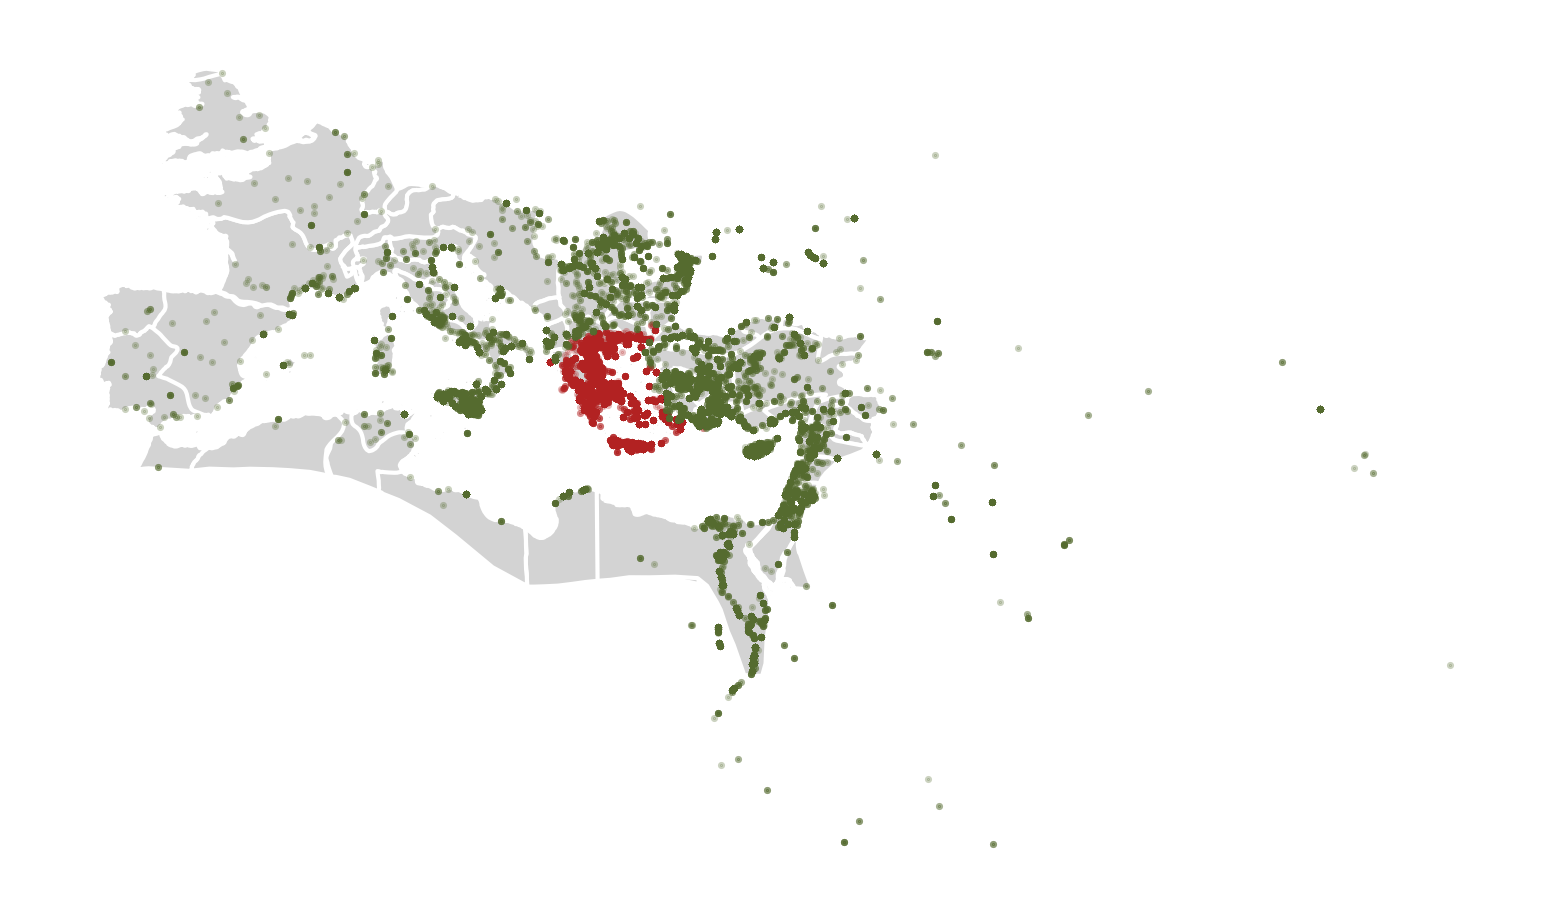

In [94]:
fig, ax = plt.subplots()
ax.axis("off")
pleiades_regions.plot(ax=ax, color="lightgrey")
#Greece.plot(ax=ax, color="black", alpha=0.5)
#gplt.kdeplot(GIST[GIST["geometry"].notnull()], cmap='Purples', ax=ax, shade=False, zorder=2)
GIST[GIST["greece?"]].plot(markersize=0.5, ax=ax, color="firebrick", alpha=0.3)
GIST[~GIST["greece?"]].plot(markersize=0.5, ax=ax, color="darkolivegreen", alpha=0.3)

<AxesSubplot:>

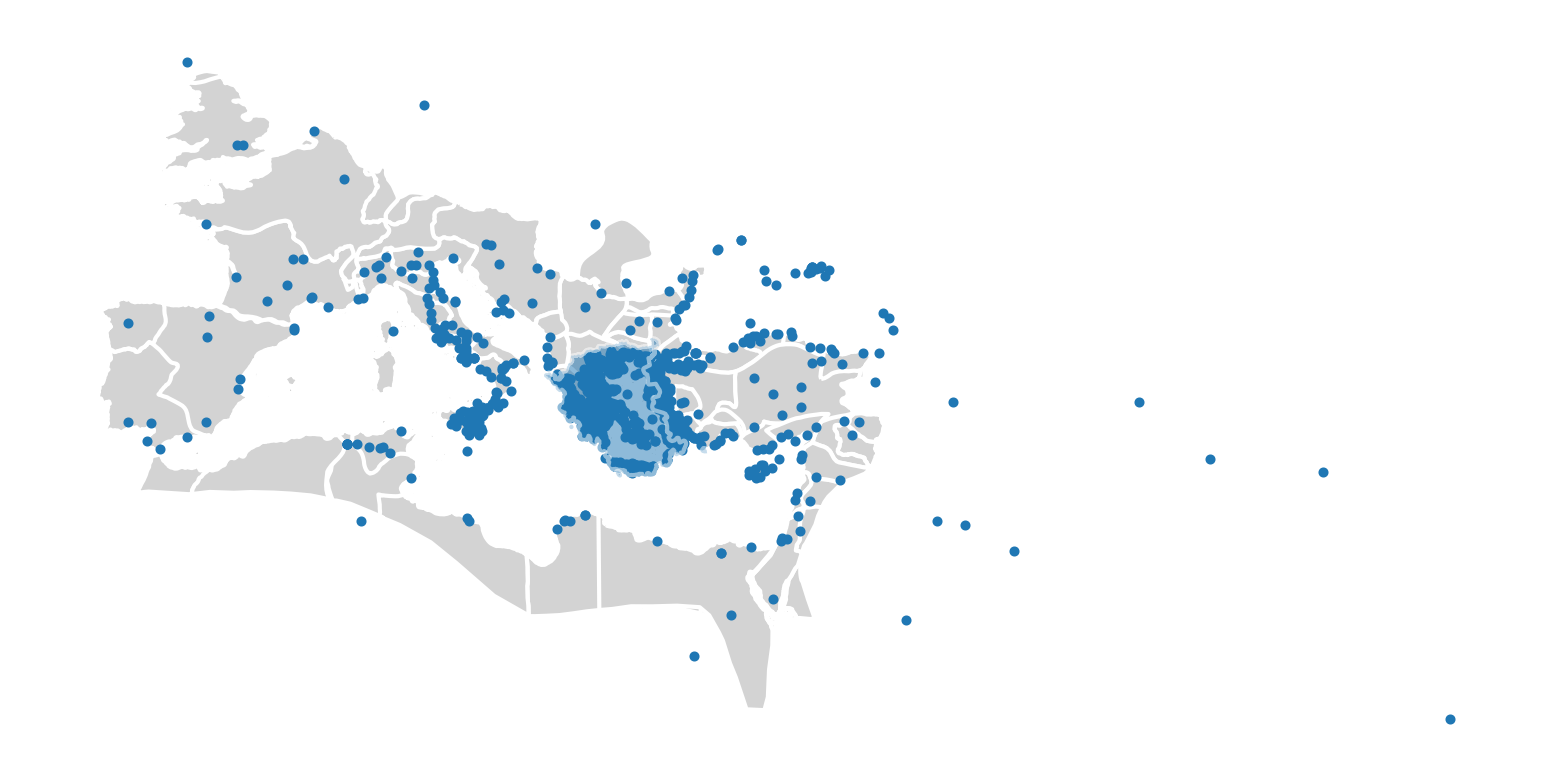

In [15]:

fig, ax = plt.subplots()
pleiades_regions.plot(ax=ax, color="lightgrey")
ax.axis("off")
pleiades_regions.plot(ax=ax, color="lightgrey")
polis.plot(ax=ax, markersize=2)
Greece.plot(ax=ax, alpha=0.5)

In [31]:
%%time
GIST["greece?"] = GIST.within(Greece_uu)

CPU times: user 1min 35s, sys: 1.78 s, total: 1min 37s
Wall time: 1min 37s


In [32]:
GIST["greece?"].sum()

74940

In [33]:
GIST = GIST[(GIST["geometry"].notnull()) & (~GIST["geometry"].is_empty)]
polis = polis[(polis["geometry"].notnull()) & (~polis["geometry"].is_empty)]

/Users/kasev/Projects/EpiMR/epimr_venv/lib/python3.9/site-packages/geopandas/geoseries.py:749: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [34]:
geod = Geod(ellps="WGS84")
def get_dist_m(inscr_geo, city_geo):
    line_string = LineString([inscr_geo, city_geo])
    return np.round(geod.geometry_length(line_string), 2)

def ckdnearest(inscriptions, polis):

    polis = polis[['name', 'geometry']]
    insr_geometries = np.array(list(inscriptions.geometry.apply(lambda x: (x.x, x.y))))
    polis_geometries = np.array(list(polis.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(polis_geometries)
    dist, idx = btree.query(insr_geometries, k=1)
    nearest_polis_df = polis.iloc[idx].rename(columns={"geometry": "polis_geo"}).reset_index(drop=True)
    nearest_polis_df["polis_geo"] = [[geom.x, geom.y] for geom in nearest_polis_df["polis_geo"]]

    merge_gdf = pd.concat(
        [
            inscriptions.reset_index(drop=True),
            nearest_polis_df,
            pd.Series(dist, name="polis_dist")
        ],
        axis=1)
    merge_gdf["polis_dist"] = merge_gdf.apply(lambda row: get_dist_m(row.geometry, row["polis_geo"]), axis=1)
    return merge_gdf

In [35]:
%%time
GIST = ckdnearest(GIST, polis)

CPU times: user 10.3 s, sys: 228 ms, total: 10.5 s
Wall time: 10.8 s


In [36]:
GIST

,PHI_ID,reference,metadata,lines,text_raw,text_iphi,clean_text_conservative,clean_text_interpretive_word,lemmata,raw_date,...,Attalus_ID,TMgeo_ID,x_long,y_lat,TMgeo_name,geometry,greece?,name,polis_geo,polis_dist
0,1,IG I³\n1,Att. — Ath.: Akr. — stoich. 35 — c. 510-500 a....,12.0,ἔδοχσεν το͂ι δέμοι· τ̣[ὸς ἐ Σ]αλαμ̣[ῖνι κλερόχ...,εδοχσεν τοι δεμοι τ[ος ε σ]αλαμ[ινι κλεροχ]ος ...,ἔδοχσεν το͂ι δέμοι ταλαμος οἰκε͂ν ἐᾶ Σαλαμῖνι ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,"{'data': ['ἔδοχσεν', 'δέμοι', 'Σαλαμίς', 'κλερ...",c. 510-500 a.,...,{'data': []},{'data': ['364']},23.723985,37.972747,Athenai,POINT (23.72399 37.97275),True,361-Athenai,"[23.7278, 37.9778]",653.43
1,4,IG I³\n4,Att. — stoich. 38 — 485/4 a.,56.0,[․․․․․․․․․․․․․․․․․․38․․․․․․․․․․․․․․․․․․]\n[․․․...,[--------------------------------------] [----...,δέ τις αν ἒ φρορὰν μ ντέκοντα δχμὰς τ ας ℎες π...,ἐὰν δέ τις αν ἒ φρορὰν μὲ πεντέκοντα δραχμὰς τ...,"{'data': ['τὶς', 'φρορὰν', 'πεντέκοντα', 'δραχ...",485/4 a.,...,{'data': []},{'data': ['364']},23.723985,37.972747,Athenai,POINT (23.72399 37.97275),True,361-Athenai,"[23.7278, 37.9778]",653.43
2,5,IG I³\n5,Att. — c. 500 a.,6.0,[ἔδοχσε]ν [⋮ τε͂ι βολε͂ι] ⋮ καὶ [τ]ο͂ι δέμοι ⋮...,[εδοχσε]ν [ τει βολει] και [τ]οι δεμοι οτε παρ...,ν καὶ ο͂ι δέμοι ℎότε Παραιβάτες λεια θν τὸς ℎι...,ἔδοχσεν τε͂ι βολε͂ι καὶ το͂ι δέμοι ℎότε Παραιβ...,"{'data': ['ἔδοχσεν', 'τει', 'βολει', 'δέμοι', ...",c. 500 a.,...,{'data': []},{'data': ['10345']},23.541498,38.044135,Eleusis,POINT (23.54150 38.04414),True,362-Eleusis,"[23.5423, 38.0394]",530.31
3,6,IG I³\n6,Att. — stoich. 23/11 — ante 460 a.,160.0,— — — — — — — — — — — — —\n[․․․․․․15․․․․․․․] δ...,------------- [---------------] δραχμεισ[ι ---...,δραχμε͂ιστες τὸς ιο μενος δεμο το͂ν πόλεο οκε͂...,δραχμε͂ισι τες τὸς ιο μενος δεμο το͂ν πόλεον δ...,"{'data': ['δραχμεισι', 'τες', 'μένος', 'δεμο',...",ante 460 a.,...,{'data': []},{'data': ['10345']},23.541498,38.044135,Eleusis,POINT (23.54150 38.04414),True,362-Eleusis,"[23.5423, 38.0394]",530.31
4,11,IG I³\n11,Att. — stoich. 48 — ante med. s. V a.,22.0,[χσυμμαχία καὶ ℎόρ]κ̣ο̣[ς] Ἀ̣[θ]ε̣ν̣α̣[ίον κα]...,[χσυμμαχια και ορ]κο[ς] α[θ]ενα[ιον κα]ι εγεστ...,κο Ἀεναὶ Ἐγεσταί ο͂ι ἐπρυτάνευε οΙ ον ἐ͂ρχε Ἀ...,χσυμμαχία καὶ ℎόρκος Ἀθεναίον καὶ Ἐγεσταίον ἔδ...,"{'data': ['χσυμμαχία', 'ὅρκος', 'ἀθεναίον', 'ἐ...",ante med. s. V a.,...,{'data': []},{'data': ['364']},23.723985,37.972747,Athenai,POINT (23.72399 37.97275),True,361-Athenai,"[23.7278, 37.9778]",653.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180056,353786,IK Strat. III\nAdd. et Corr. 645,Caria — Lagina — Rom. Imp. period? — IK Strato...,2.0,[Ἀρισ]τείδης Ἱεροκλέους τοῦ Θευδώρου [— —]\n,[αρισ]τειδης ιεροκλεους του θευδωρου [--].,τείδης Ἱεροκλέους τοῦ Θευδώρου,Ἀριστείδης Ἱεροκλέους τοῦ Θευδώρου,"{'data': ['ἀριστείδης', 'ἱεροκλέους', 'θευδώρο...",Rom. Imp. period?,...,{'data': []},{'data': ['16160']},28.038562,37.377952,Lagina,POINT (28.03856 37.37795),False,892-Idrias,"[28.16666667, 37.25]",18182.66
180057,353787,IK Strat. III\nAdd. et Corr. 712,Caria — Lagina — Rom. Imp. period? — IK Strato...,3.0,[Ἄπφιον] Ἀρτεμιδώ-\n[ρου] ...\n,[απφιον] αρτεμιδω[ρου].,Ἀρτεμιδώ,Ἄπφιον Ἀρτεμιδώρου,"{'data': ['ἄπφιον', 'ἀρτεμιδώρου']}",Rom. Imp. period?,...,{'data': []},{'data': ['16160']},28.038562,37.377952,Lagina,POINT (28.03856 37.37795),False,892-Idrias,"[28.16666667, 37.25]",18182.66
180058,353788,IK Strat. III\nAdd. et Corr. 809,Caria — Stratonikeia — Yeşilbağcılar — Helleni...,2.0,καὶ κριὸν [— —]\n,και κριον [--].,καὶ κριὸν,καὶ κριὸν,{'data': ['κριός']},Hellenistic period,...,{'data': []},{'data': ['2201']},28.064500,37.313590,Stratonikeia,POINT (28.06450 37.31359),False,892-Idrias,"[28.16666667, 37.25]",11484.64
180059,353789,IK Strat. III\nAdd. et Corr. 1002,Caria — Stratonikeia — 276 BC — IK Stratonikei...,6.0,"․ος Μ[αν]εω, [Πιγ?]ραμος Υσσω-\nλο[υ] ...\n......",-ος 0[αν]εω [πιγ]ραμος υσσωλο[υ]. χος δερσω[--...,ος Μεω ραμος Υσσωλο χος Δερσωτις Νωτραος,ος Μανεω Πιγρα

In [37]:
GIST["polis?"] = GIST["polis_dist"] < 5000

# Exploring temporal distribution

In [38]:
def get_duration(start, stop):
    try:
        duration = abs(int(start) - int(stop)) + 1
        if 0 in range(int(start),  int(stop)):
            duration = duration - 1
    except:
        duration = np.nan
    return duration

GIST["duration"] = GIST.apply(lambda row: get_duration(row["not_before"], row["not_after"]), axis=1)

(-5.0, 305.0)

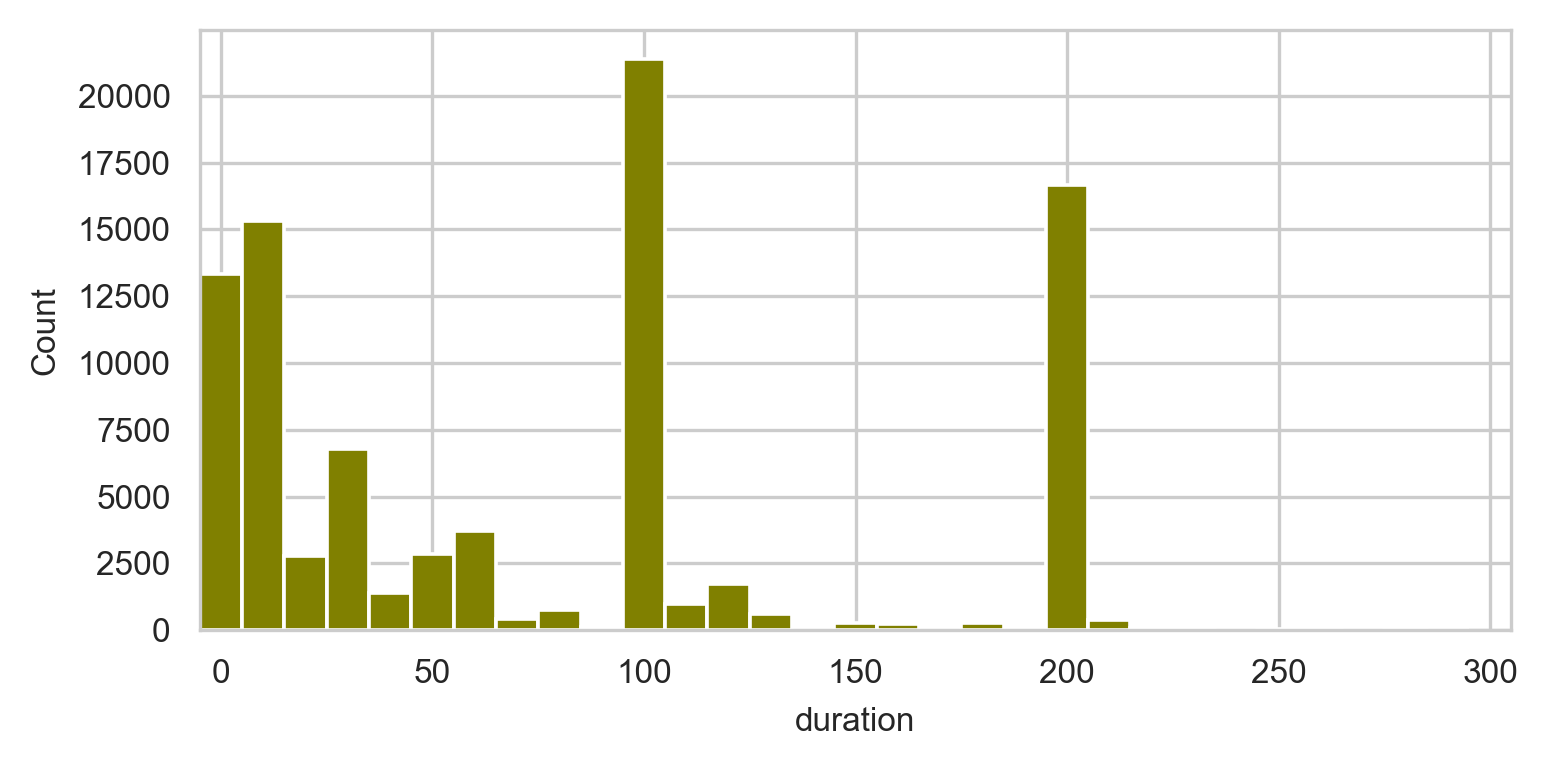

In [39]:
fig, ax = plt.subplots(figsize=(5.2, 2.6), tight_layout=True)
sns.histplot(GIST["duration"], kde=False, bins=range(-5, 305,10), alpha=1, color="olive", ax=ax)
ax.set_xlim(-5, 305)

In [40]:
GIST["random_dates"] = GIST.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=100), axis=1)

In [41]:
LIST = gpd.read_parquet("../../LIRE_ETL/data/large_data/LIST_v0.1.parquet")

In [43]:
LIST["random_dates"] = LIST.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=100), axis=1)

In [53]:
len(LIST)

157800

In [51]:
sum((LIST["not_before"].notnull()) | (LIST["not_after"].notnull()))

157800

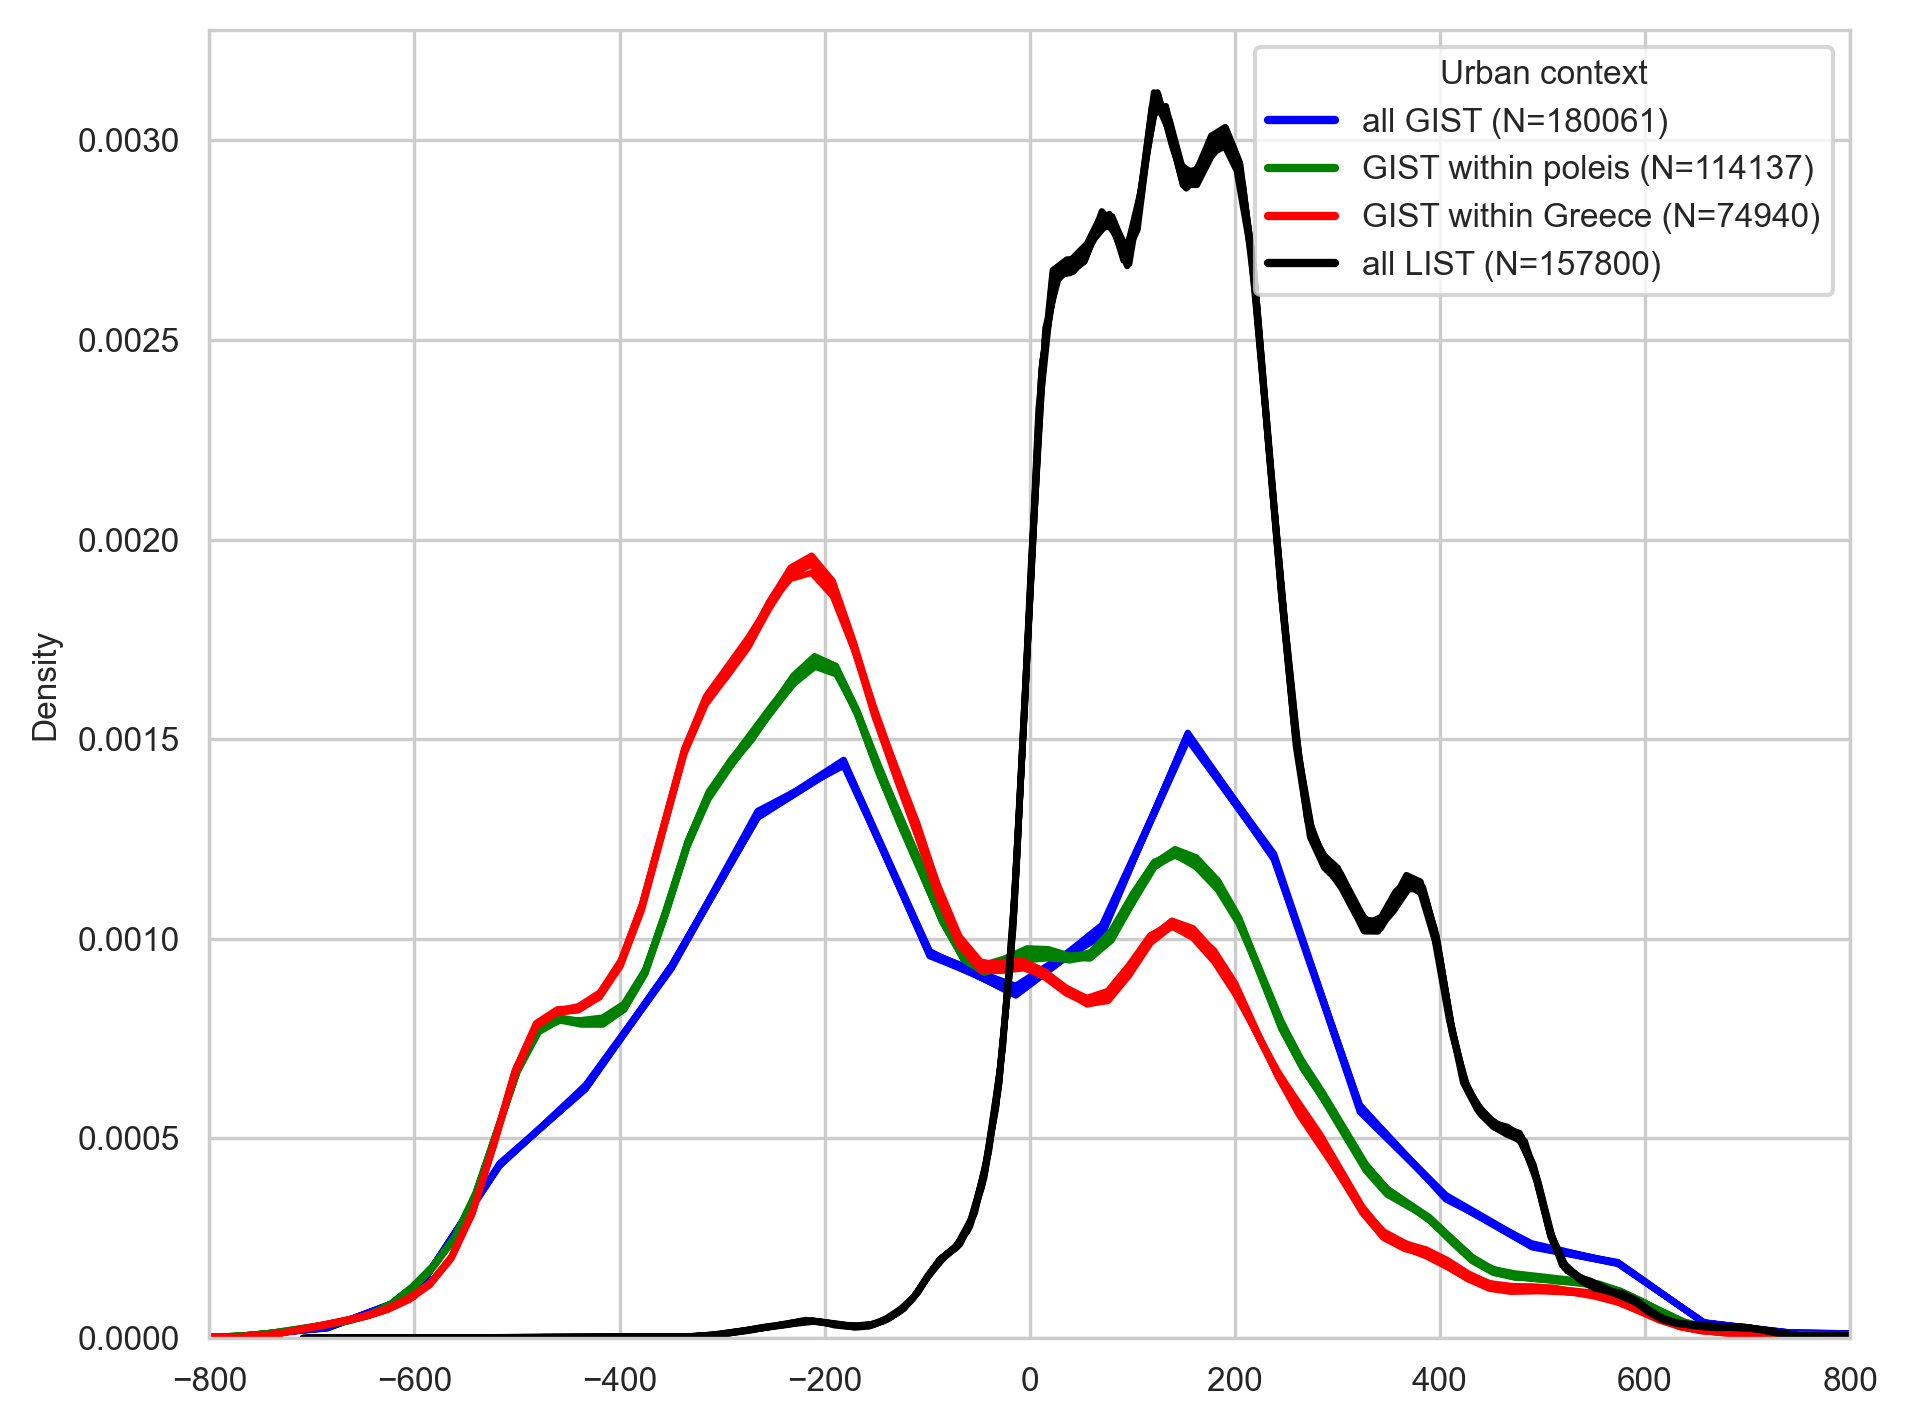

In [55]:
fig, ax = plt.subplots(tight_layout=True)
tempun.kdeplot_from_randoms(GIST["random_dates"], ax=ax,color="blue", random_size=10)
tempun.kdeplot_from_randoms(GIST[GIST["polis?"]]["random_dates"], ax=ax, color="green", random_size=10)
tempun.kdeplot_from_randoms(GIST[GIST["greece?"]]["random_dates"], ax=ax, color="red", random_size=10)
tempun.kdeplot_from_randoms(LIST["random_dates"], ax=ax, color="black", random_size=10)
ax.set_xlim(-800,800)

legend_labels = ["all GIST (N={})".format(str(len(GIST))),
                 "GIST within poleis (N={})".format(str(sum(GIST["polis?"]))),
                 "GIST within Greece (N={})".format(str(sum(GIST["greece?"]))),
                 "all LIST (N={})".format(str(len(LIST)))]
colors=["blue", "green", "red", "black"]
markers = [plt.Line2D([0,0],[0,0],color=color, lw=2) for color in colors]
ax.legend(markers, legend_labels, numpoints=1,  title="Urban context", bbox_to_anchor=(1, 1), loc='upper right')

In [61]:
[el+1 if el==0 else el for el in range(-800,500,100)]

[-800, -700, -600, -500, -400, -300, -200, -100, 1, 100, 200, 300, 400]

In [74]:
GIST = GIST[GIST["random_dates"].notnull()]

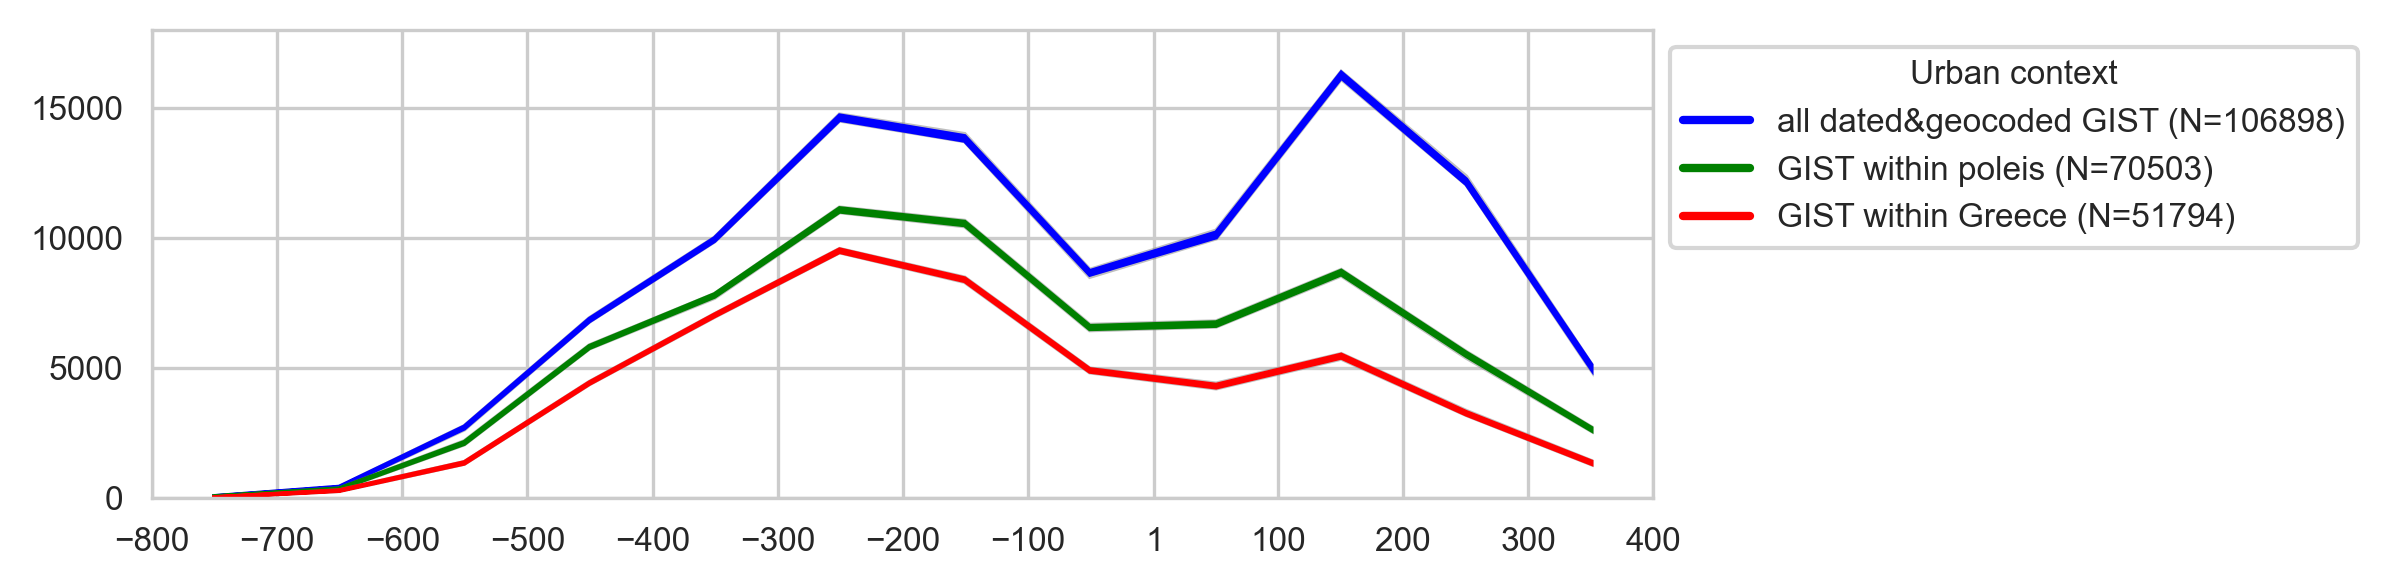

In [77]:
fig, ax = plt.subplots(figsize=(8,2), tight_layout=True)
random_size=100
tempun.timeblocksplot_from_randoms(GIST["random_dates"], ax=ax,color="blue", timeblocks=[-800,400,100], random_size=random_size)
tempun.timeblocksplot_from_randoms(GIST[GIST["polis?"]]["random_dates"], ax=ax, color="green", timeblocks=[-800,400,100], random_size=random_size)
tempun.timeblocksplot_from_randoms(GIST[GIST["greece?"]]["random_dates"], ax=ax, color="red", timeblocks=[-800,400,100], random_size=random_size)
#tempun.timeblocksplot_from_randoms(LIST["random_dates"], ax=ax, color="darkgrey", timeblocks=[-800,400,100], random_size=10)
ax.set_xlim(-800,400)
ax.set_ylim(0,18000)
ax.set_xticks([el+1 if el==0 else el for el in range(-800,500,100)])


legend_labels = ["all dated&geocoded GIST (N={})".format(str(len(GIST))),
                 "GIST within poleis (N={})".format(str(sum(GIST["polis?"]))),
                 "GIST within Greece (N={})".format(str(sum(GIST["greece?"])))]
                 #"all LIST (N={})".format(str(len(LIST)))]
colors=["blue", "green", "red"] #, "darkgrey"]
markers = [plt.Line2D([0,0],[0,0],color=color, lw=2) for color in colors]
ax.legend(markers, legend_labels, numpoints=1,  title="Urban context", bbox_to_anchor=(1, 1), loc='upper left')

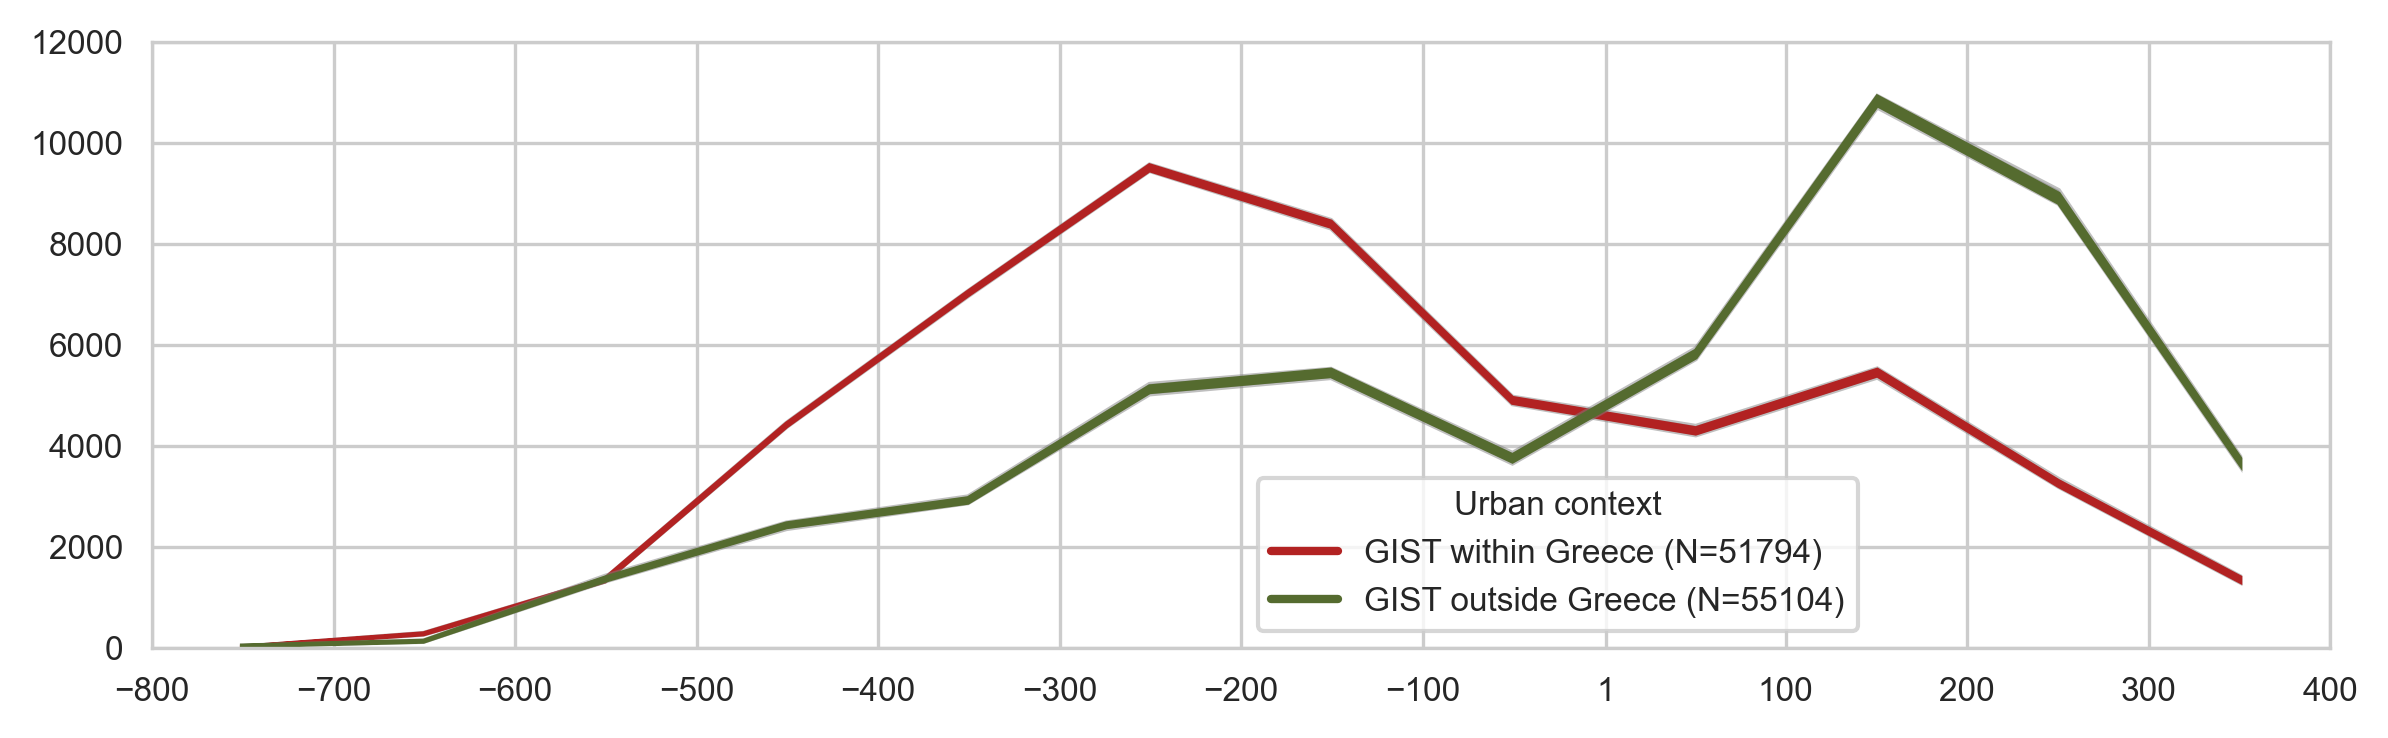

In [95]:
fig, ax = plt.subplots(figsize=(8,2.5), tight_layout=True)
random_size=100
tempun.timeblocksplot_from_randoms(GIST[GIST["greece?"]]["random_dates"], ax=ax, color="firebrick", timeblocks=[-800,400,100], random_size=random_size)
tempun.timeblocksplot_from_randoms(GIST[~GIST["greece?"]]["random_dates"], ax=ax, color="darkolivegreen", timeblocks=[-800,400,100], random_size=random_size)
#tempun.timeblocksplot_from_randoms(LIST["random_dates"], ax=ax, color="darkgrey", timeblocks=[-800,400,100], random_size=10)
ax.set_xlim(-800,400)
ax.set_ylim(0,12000)
ax.set_xticks([el+1 if el==0 else el for el in range(-800,500,100)])


legend_labels = [
                 "GIST within Greece (N={})".format(str(sum(GIST["greece?"]))),
                 "GIST outside Greece (N={})".format(str(sum(~GIST["greece?"])))]
#"all LIST (N={})".format(str(len(LIST)))]
colors=["firebrick", "darkolivegreen"] #, "darkgrey"]
markers = [plt.Line2D([0,0],[0,0],color=color, lw=2) for color in colors]
ax.legend(markers, legend_labels, numpoints=1,  title="Urban context", bbox_to_anchor=(0.5, 0), loc='lower left')

In [100]:
data = []
for cent in range(-8, 4):
    if cent < 0:
        cent_start, cent_end = cent * 100, cent * 100 + 99
        cent_label = "{} BCE".format(str(abs(cent)))
    else:
        cent_start, cent_end = cent * 100 + 1, cent * 100 + 100
        cent_label = "{} CE".format(str(cent + 1))
    subset = GIST[GIST["random_dates"].apply(lambda x: cent_start < x[0] < cent_end)]
    words_N = sum(subset["clean_text_interpretive_word"].apply(lambda x: len(x.split())))
    data.append({"cent_raw": cent,  "cent_label" : cent_label, "inscr_N" : len(subset), "words_N" : words_N})

In [102]:
cent_overview = pd.DataFrame(data)
cent_overview

,cent_raw,cent_label,inscr_N,words_N
0,-8,8 BCE,58,282
1,-7,7 BCE,407,1886
2,-6,6 BCE,2577,14827
3,-5,5 BCE,6656,68493
4,-4,4 BCE,9626,279109
5,-3,3 BCE,14309,495434
6,-2,2 BCE,13392,635146
7,-1,1 BCE,8519,197672
8,0,1 CE,9951,185373
9,1,2 CE,15958,321728


In [113]:
for n in range(len(cent_overview)):
    x, y, label = cent_overview.iloc[n]["cent_raw"], cent_overview.iloc[n]["inscr_N"], str(cent_overview.iloc[n]["inscr_N"])
    print(x, y, label)

-8 58 58
-7 407 407
-6 2577 2577
-5 6656 6656
-4 9626 9626
-3 14309 14309
-2 13392 13392
-1 8519 8519
0 9951 9951
1 15958 15958
2 11831 11831
3 4928 4928


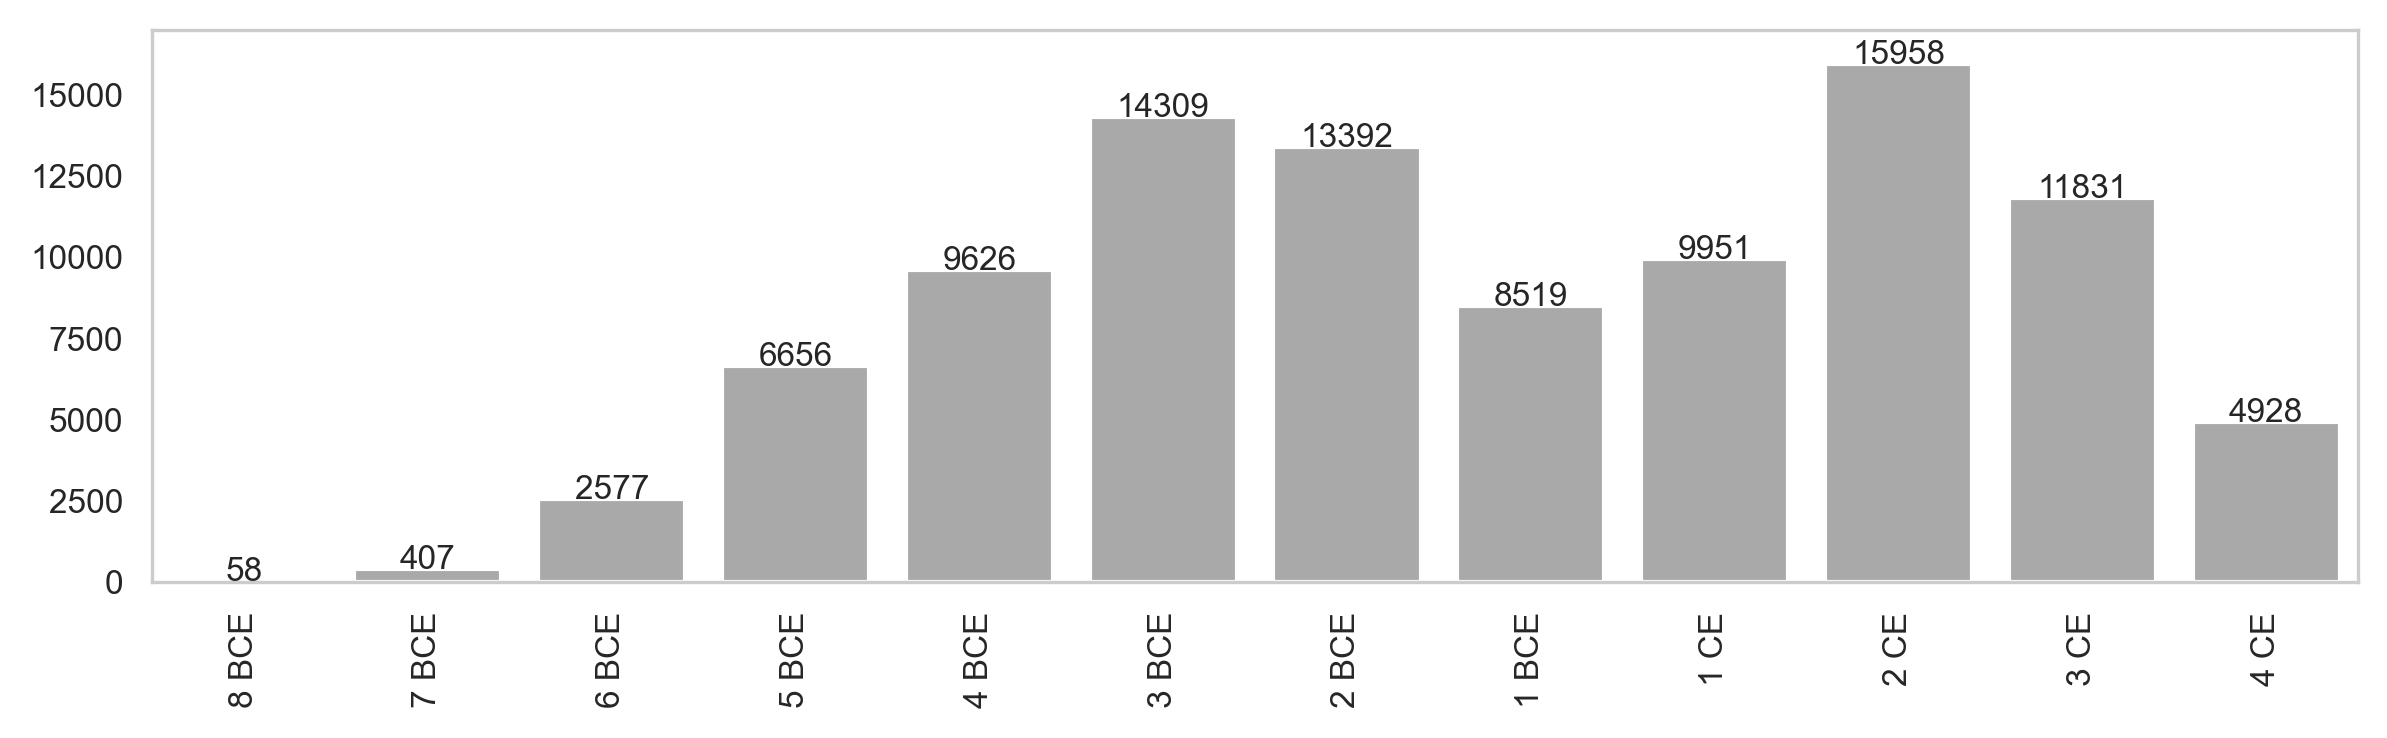

In [119]:
fig, ax = plt.subplots(figsize=(8,2.5), tight_layout=True)
ax.bar(cent_overview["cent_raw"], cent_overview["inscr_N"], color="darkgrey")
ax.set_xlim(-8.5,3.5)
ax.set_ylim(0,17000)
ax.set_xticks(cent_overview["cent_raw"])
ax.set_xticklabels(cent_overview["cent_label"], rotation=90)
for n in range(len(cent_overview)):
    x, y, label = cent_overview.iloc[n]["cent_raw"], cent_overview.iloc[n]["inscr_N"], str(cent_overview.iloc[n]["inscr_N"])
    ax.text(x=x, y=y, s=label, horizontalalignment="center")
ax.grid(False)

In [58]:
#!mkdir ../data/large_files
GIST.to_parquet("../data/large_files/GIST_geocontexts.parquet")

In [62]:

pottery = pd.read_csv("../data/large_files/Pottery.tsv",  sep='\t')
pottery.head()

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_89358/3589442655.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  pottery = pd.read_csv("../data/large_files/Pottery.tsv",  sep='\t')


,URI,Vase Number,Fabric,Technique,Sub Technique,Shape Name,Provenance,Date,Inscriptions,Attributed To,...,Inscriptions II,Measurements,Volume,Weight,Restorations,Ornament,Technical Observations,Pleiades URI,Latitude,Longitude
0,"<a href=""javascript:return(false);"" onclick=""w...",1.0,ATHENIAN,BLACK-FIGURE,NaN,"AMPHORA, NECK","ITALY, ETRURIA, VULCI",-525 to -475,NaN,CHIUSI P by KUNZE-GOTTE | LEAGROS GROUP by KUN...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"<a href=""javascript:return(false);"" onclick=""w...",42.421429,11.702499
1,"<a href=""javascript:return(false);"" onclick=""w...",2.0,ATHENIAN,BLACK-FIGURE,NaN,"KRATER, COLUMN FRAGMENT","GREECE, ATHENS, AGORA",-550 to -500,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"<a href=""javascript:return(false);"" onclick=""w...",3.0,ATHENIAN,BLACK-FIGURE,NaN,"AMPHORA, NECK","ITALY, ETRURIA, VULCI",-550 to -500,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"<a href=""javascript:return(false);"" onclick=""w...",42.421429,11.702499
3,"<a href=""javascript:return(false);"" onclick=""w...",4.0,ATHENIAN,BLACK-FIGURE,NaN,"AMPHORA, NECK",NaN,-550 to -500,NaN,<em>Near</em> MEDEA GROUP by UNKNOWN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"<a href=""javascript:return(false);"" onclick=""w...",5.0,ATHENIAN,BLACK-FIGURE,NaN,"AMPHORA, NECK",NaN,-525 to -475,NaN,ANTIMENEAN by KUNZE-GOTTE | DAYBREAK P by POUI...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
sum(pottery["Longitude"].notna())

29889

In [68]:
def split_date(date_string, n):
    try:
        date_string = date_string.partition(" to ")[n]
    except:
        pass
    try:
        date_string = int(date_string)
    except:
        pass
    return date_string
pottery["not_before"] = pottery["Date"].apply(lambda x: split_date(x, 0))
pottery["not_after"] = pottery["Date"].apply(lambda x: split_date(x, 2))


In [69]:
pottery

,URI,Vase Number,Fabric,Technique,Sub Technique,Shape Name,Provenance,Date,Inscriptions,Attributed To,...,Volume,Weight,Restorations,Ornament,Technical Observations,Pleiades URI,Latitude,Longitude,not_before,not_after
0,"<a href=""javascript:return(false);"" onclick=""w...",1.0,ATHENIAN,BLACK-FIGURE,NaN,"AMPHORA, NECK","ITALY, ETRURIA, VULCI",-525 to -475,NaN,CHIUSI P by KUNZE-GOTTE | LEAGROS GROUP by KUN...,...,NaN,NaN,NaN,NaN,NaN,"<a href=""javascript:return(false);"" onclick=""w...",42.421429,11.702499,-525,-475
1,"<a href=""javascript:return(false);"" onclick=""w...",2.0,ATHENIAN,BLACK-FIGURE,NaN,"KRATER, COLUMN FRAGMENT","GREECE, ATHENS, AGORA",-550 to -500,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-550,-500
2,"<a href=""javascript:return(false);"" onclick=""w...",3.0,ATHENIAN,BLACK-FIGURE,NaN,"AMPHORA, NECK","ITALY, ETRURIA, VULCI",-550 to -500,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"<a href=""javascript:return(false);"" onclick=""w...",42.421429,11.702499,-550,-500
3,"<a href=""javascript:return(false);"" onclick=""w...",4.0,ATHENIAN,BLACK-FIGURE,NaN,"AMPHORA, NECK",NaN,-550 to -500,NaN,<em>Near</em> MEDEA GROUP by UNKNOWN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-550,-500
4,"<a href=""javascript:return(false);"" onclick=""w...",5.0,ATHENIAN,BLACK-FIGURE,NaN,"AMPHORA, NECK",NaN,-525 to -475,NaN,ANTIMENEAN by KUNZE-GOTTE | DAYBREAK P by POUI...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-525,-475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130338,"<a href=""javascript:return(false);"" onclick=""w...",9052531.0,ATHENIAN,RED-FIGURE,NaN,LEKYTHOS,NaN,-500 to -450,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-500,-450
130339,"<a href=""javascript:return(false);"" onclick=""w...",9052532.0,ATHENIAN,RED-FIGURE,NaN,PELIKE,NaN,-450 to -400,NaN,WASHING P by UNKNOWN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-450,-400
130340,"<a href=""javascript:return(false);"" onclick=""w...",9052533.0,ATHENIAN (?),BLACK-FIGURE,NaN,PYXIS,NaN,-575 to -525,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-575,-525
130341,"<a href=""javascript:return(false);"" onclick=""w...",9052534.0,ATHENIAN,BLACK-FIGURE,NaN,LEKYTHOS,NaN,-500 to -450,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-500,-450


In [71]:
sum(pottery["not_before"].notna())

96800